# Simon's Algorithm

## Problem statement:

Given: a function $f$ acting on bit strings $f:\{0,1\}^n \rightarrow \{0,1\}^n$ and a promise that $f(x)=f(x \oplus s)$ for all $x$ (addition mod 2). The goal is to use Simon's algorithm to find the unknown string $s$.




### Example:

For example, if $n = 3$, then the following function is an example of a function that satisfies the required and just mentioned property:

|$x$|   $$f(x)$$|
|---|------|
|000|	101|
|001|	010|
|010|	000|
|011|	110|
|100|	000|
|101|	110|
|110|	101|
|111|	010|



Given $f$ is a two-to-one function i.e. it maps exactly two inputs to every unique output, and we find 2 values of input $x$ that have the same output, $f(x_1)=f(x_2)$ then it is guaranteed that $x_1 \oplus x_2 = s$

For example, the input strings $011$ and $101$ are both mapped by $f$ to the same output string $110$. If we XOR $011$ and $101$ we obtain $s$, that is:

$$011 \oplus 101 = 110$$

so for this example $s = 110$

## Problem hardness

To solve this classically, you need to find two different inputs $x$ and $y$ for which $f(x)=f(y)$. Given $f$ is a blackbox, we can discover something about $f$ (or what it does) only when, for two different inputs, we obtain the same output. In any case, we would need to guess $ \Omega ({\sqrt {2^{n}}})$ different inputs before being likely to find a pair on which $f$ takes the same output.

## Simon's Algorithm

The high-level idea behind Simon's algorithm is to "probe" a quantum circuit "enough times" to find $n-1$ (linearly independent) n-bit strings, that is

$$ y_{1},y_{2},\dots ,y_{n-1}\in \{0,1\}^{n} $$

such that the following equations are satisfied

$$ \begin{aligned}y_{1}\cdot s&=0\\y_{2}\cdot s&=0\\&\,\,\,\vdots \\y_{n-1}\cdot s&=0\end{aligned}$$ 


where $ y_{i}\cdot s$ is the modulo-2 dot product; that is, $ y_{i}\cdot s=y_{i1}s_{1}\oplus y_{i2}s_{2}\oplus \dots \oplus y_{in}s_{n} $

So, this linear system contains $n-1$ linear equations in $n$ unknowns (i.e. the bits of $s$, and the goal is to solve it to obtain $s$, and $s$ is fixed for a given function $f$.


### Simon's quantum circuit

The quantum circuit below is the implementation (and visualization) of the quantum part of Simon's algorithm.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fb/Simons_algorithm.svg"/>

The circuit acts on $2n$ qubits (where $n$ is the length of the bit string in question (i.e., $n=3$ for our example). Apply a Hadamard gate to the first $n$ qubits, then apply $U_f$ - which is an oracle (or "black box"), which knows how to compute $f$ , then apply a Hadamard gate to the first $n$ qubits.

For more details on Simon's algorithm refer to [Wikipedia](<https://en.wikipedia.org/wiki/Simon%27s_problem#Simon's_algorithm>)


## Import related lib

In [1]:
from braket.devices import LocalSimulator
from braket.circuits import Circuit
import random
import matplotlib.pyplot as plt

In [2]:
# the following are imported for matrix computing to resolve the final equation set.
from sympy import Matrix, pprint, MatrixSymbol, expand, mod_inverse

In [3]:
# define the quantum device.
# use LocalSimulator so that it can be run locally with Braket SDK installed.
device = LocalSimulator()

In [4]:
def generate_oracle(secret_s):
    
    # validating input secret s:
    first_1_bit_location = -1
    other_1_bit_location_list = list()
    
    for index,bit_value in enumerate(secret_s):
        if (bit_value != '0' and bit_value != '1'):
            raise Exception ('Incorrect char \'' + bit_value + '\' in secret string S:' + secret_s)
        else:
            if (bit_value == '1'):
                if (first_1_bit_location == -1):
                    first_1_bit_location = index
                else:
                    other_1_bit_location_list.append(index)
                
    if (first_1_bit_location == -1):
        raise Exception (' All 0 in secret string S')
            
    n = len(str(secret_s))
    
    oracle_circuit = Circuit()

        
    oracle_circuit.cnot(first_1_bit_location, first_1_bit_location+n)
    
    for other_1_bit_location in other_1_bit_location_list:
        oracle_circuit.cnot(first_1_bit_location, other_1_bit_location)
        
    for i in range(n):
        oracle_circuit.cnot(i, n+i)
        
    for other_1_bit_location in other_1_bit_location_list:
        oracle_circuit.cnot(first_1_bit_location, other_1_bit_location)
                
    return oracle_circuit

In [5]:
def generate_input_circuit(source_list):
    
    input_circuit_list = list()
    
    for input_index, digit_string in enumerate(source_list):
        cur_circuit = Circuit()
        for reg_index, digit_value in enumerate(digit_string):
            if (digit_value == '0'):
                cur_circuit.i(reg_index)
            elif (digit_value == '1'):
                cur_circuit.x(reg_index)
            else:
                raise Exception('incorrect input value: \'' + digit_value + '\' in: ' + digit_string )
        
        input_circuit_list.append(cur_circuit)
        
    return input_circuit_list

In [6]:
def generate_simon_circuit(secret_s):
    
    bit_number = len(secret_s)
        
    oracle_circuit = generate_oracle(secret_s)
    
    input_circuit = Circuit()
    
    for i in range(bit_number):
        input_circuit.h(i)
        
    output_circuit = Circuit()
    
    for i in range(bit_number):
        output_circuit.h(i)
        
    simon_circuit = input_circuit + oracle_circuit + output_circuit
    
    return simon_circuit
    
    
    
    

In [7]:
def generate_full_bit_string(bit_number):
    zero_string = '0' * bit_number
    result_list = list()
    for i in range(pow(2, bit_number)):
        cur_string = (zero_string + bin(i)[2:])[-bit_number:]
        result_list.append(cur_string)
    return result_list

In [8]:
def generate_random_secret_s(start=2, end=8):
    random_bit_number = random.randint(start, end)
    
    secret_s_list = generate_full_bit_string(random_bit_number)[1:]
    
    candidate_number = len(secret_s_list)
    
    random_index = random.randint(0,candidate_number-1)
    
    selected_secret_s = secret_s_list[random_index]
    
    return selected_secret_s

In [9]:
secret_s = generate_random_secret_s()

In [10]:
secret_s

'10101010'

In [11]:
bit_number = len(secret_s)

In [12]:
simon_circuit = generate_simon_circuit(secret_s)

In [13]:
print(simon_circuit)

T   : |0|    1    | 2 | 3 | 4 | 5 |6| 7 | 8 |9|
                                               
q0  : -H-C---------C---C---C---C---C-C---C---H-
         |         |   |   |   |   | |   |     
q1  : -H-|-C-------|-H-|---|---|---|-|---|-----
         | |       |   |   |   |   | |   |     
q2  : -H-|-|-------X---|-C-|---|---X-|-H-|-----
         | |           | | |   |     |   |     
q3  : -H-|-|-C-----H---|-|-|---|-----|---|-----
         | | |         | | |   |     |   |     
q4  : -H-|-|-|---------X-|-|-C-|-----X---|-H---
         | | |           | | | |         |     
q5  : -H-|-|-|-C---H-----|-|-|-|---------|-----
         | | | |         | | | |         |     
q6  : -H-|-|-|-|---------|-X-|-|-C-------X---H-
         | | | |         |   | | |             
q7  : -H-|-|-|-|-C-H-----|---|-|-|-------------
         | | | | |       |   | | |             
q8  : ---X-|-|-|-|-------|---|-X-|-------------
           | | | |       |   |   |             
q9  : -----X-|-|-|-------|---|---|------

In [14]:
# run 2 * bit_number times to get the y output
# according to Simon's algorithm, we only need bit_number-1 independent y to caculate s
# in real world, we may get y with all zeros or dependent y, 
# running bit_number-1 time is not enough to get bit_number-1 independent y
# so we run 2 * bit_number times to generate y, 
# the complexity is O(2*bit_number), which is still O(bit_number), aka O(n)

task = device.run(simon_circuit, shots=bit_number*2)
result = task.result()
print (result.measurement_counts)

Counter({'0010011001101111': 1, '0001111100101100': 1, '1111010101111000': 1, '0001010001110001': 1, '1110000000100100': 1, '1011111000010011': 1, '1111101000100001': 1, '1011111001110101': 1, '0111100001000010': 1, '1001100000101111': 1, '0101000101001010': 1, '0100111100000011': 1, '1011111001110010': 1, '1000011001011001': 1, '1000100101011100': 1, '0010001001110100': 1})


measurement_of_input_registers: {'00100110': 1, '00011111': 1, '11110101': 1, '00010100': 1, '11100000': 1, '10111110': 3, '11111010': 1, '01111000': 1, '10011000': 1, '01010001': 1, '01001111': 1, '10000110': 1, '10001001': 1, '00100010': 1}



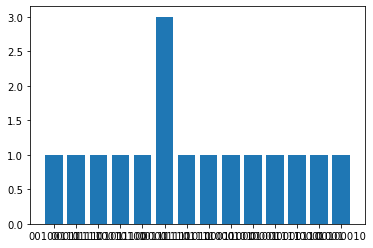

In [15]:
# Simulate partial measurement by seperating out first n bits
answer_plot = {}
for measresult in result.measurement_counts.keys():
    measresult_input = measresult[:bit_number]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += result.measurement_counts[measresult]
    else:
        answer_plot[measresult_input] = result.measurement_counts[measresult] 

print(f"measurement_of_input_registers: {answer_plot}\n")
plt.bar(answer_plot.keys(), answer_plot.values())
plt.show()

In [16]:
lAnswer = [ (k,v) for k,v in answer_plot.items() if k != "0"*bit_number  ] #excluding the trivial all-zero
Y = []
for k, v in lAnswer:
    Y.append( [ int(c) for c in k ] )
    
print('The output we got:')
for a in Y:
    print (a)

The output we got:
[0, 0, 1, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 1, 0, 1]
[0, 0, 0, 1, 0, 1, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 1, 0]
[0, 1, 1, 1, 1, 0, 0, 0]
[1, 0, 0, 1, 1, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 1]
[0, 1, 0, 0, 1, 1, 1, 1]
[1, 0, 0, 0, 0, 1, 1, 0]
[1, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 1, 0, 0, 0, 1, 0]


In [17]:
def mod(x,modulus):
    numer, denom = x.as_numer_denom()
    return numer*mod_inverse(denom,modulus) % modulus

In [18]:
Y = Matrix(Y)
Y_transformed = Y.rref(iszerofunc=lambda x: x % 2==0)
Y_new = Y_transformed[0].applyfunc(lambda x: mod(x,2)) #must takecare of negatives and fractional values
for row_index in range(Y_new.shape[0]):
    print (Y_new.row(row_index))

Matrix([[1, 0, 0, 0, 0, 0, 1, 0]])
Matrix([[0, 1, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 1, 0, 0, 0, 1, 0]])
Matrix([[0, 0, 0, 1, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 1, 0, 1, 0]])
Matrix([[0, 0, 0, 0, 0, 1, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 1]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])
Matrix([[0, 0, 0, 0, 0, 0, 0, 0]])


In [19]:
print("The hidden bistring s[ 0 ], s[ 1 ]....s[",bit_number-1,"] is the one satisfying the following system of linear equations:")
rows, cols = Y_new.shape
result_s = ['0']*bit_number
for r in range(rows):
    
    location_list = list()
    for i,v in enumerate(list(Y_new[r,:])):
        if (v == 1):
            location_list.append(i)
            
    if (len(location_list) == 1):
        print ('s[ ' + str(location_list[0]) +' ] = 0')
    elif (len(location_list) > 1):
        for location in location_list:
            result_s[location] = '1'
        Yr = [ "s[ "+str(location)+" ]" for location in location_list ]
        tStr = " + ".join(Yr)
        print(tStr, "= 0")
        
result_s = ''.join(result_s)

print()
print ('Which is:  ' + result_s)

The hidden bistring s[ 0 ], s[ 1 ]....s[ 7 ] is the one satisfying the following system of linear equations:
s[ 0 ] + s[ 6 ] = 0
s[ 1 ] = 0
s[ 2 ] + s[ 6 ] = 0
s[ 3 ] = 0
s[ 4 ] + s[ 6 ] = 0
s[ 5 ] = 0
s[ 7 ] = 0

Which is:  10101010


In [20]:
# check whether result_s is equal to secret_s:

if (result_s == secret_s):
    print ('We found the answer')
    print ('\tsecret string:' + secret_s)
    print ('\tresult string:' + result_s)
else:
    print ('Error, the answer is wrong')

We found the answer
	secret string:10101010
	result string:10101010


### Appendix

How did we design the Oracle circuit.

The following cells explain how we designed the Oracle circuit, using an specified secret_s: 0110.

#### Basic idea

Say that we have a secret string '0110', we want to generate an Oracle circuit with this secret string.

The bit bumber of '0110' is 4, so the input qbit number should be 4.

For all the possible inputs from '0000' to '1111', we can seperate them into two groups: x1 and x2, base on the rule of Simon's problem:

$$x1 \oplus x2 = s$$

Put x1 in column 1, x2 in column 2 and secret string in column 3, we got the following table:

|  x1   | x2  | s
|  ----  | ----  |----  |
| 0000  | 0110 | 0110 |
| 0001  | 0111 | 0110 |
| 0010  | 0100 | 0110 |
| 0011  | 0101 | 0110 |
| 1000  | 1110 | 0110 |
| 1001  | 1111 | 0110 |
| 1010  | 1100 | 0110 |
| 1011  | 1101 | 0110 |


After analyzing the table, we found that we can seperate all the inputs base on the second bit of x.

In column 1, all the second bit of x1 is 0, while in column 2, all the second bit of x2 is 1.

    x1[1] = 0
    x2[1] = 1

In fact, for any location $j$, if $s[j] = 1$, we can use bit number $j$ to seperate all the inputs into two groups which meet the requirement of Simon's Oracle.

In our example, when s is '0110', we can use the third bit too. Of course, we will seperate the intputs in different way if we use the third bit.

+ this is the first key thing we identified, use the location $j$ where we find the first 1 in secret string s. To seperate the inputs into two groups.


As all elements in x1 (which is column 1 in the table) are different from each other, we can use the x1 as the output of the ciruit, this will meet the requirement of Simon's Oracle cuircuit:

|  x1   | x2  | s | y (=x1)
|  ----  | ----  |----  |----  |
| 0000  | 0110 | 0110 |0000  |
| 0001  | 0111 | 0110 |0001  |
| 0010  | 0100 | 0110 |0010  |
| 0011  | 0101 | 0110 |0011  |
| 1000  | 1110 | 0110 |1000  |
| 1001  | 1111 | 0110 |1001  |
| 1010  | 1100 | 0110 |1010  |
| 1011  | 1101 | 0110 |1011  |

From the requirement: $x1 \oplus x2 = s$, we know that $x2 \oplus s = x1$

So, for all the x2, we can make $ y = x1 =  x2 \oplus s $ 

The basic logic of our circuit is:

    j = the location of first 1 we found in secret_s
    if ( input_x[j] == 0):
        y = input_x
    elif (input_x[j] == 1):
        y = input_x[j] XOR secret_s
        
+ This is the second key thing we indentified: XOR the input $x$ with $s$ if bit $j$ in $s$ is $1$


#### Implemetation

The question left to us is how to implement the basic logic in quantum circuit

In [21]:
# we have the secret string '0110'
secret_s = '0110'

# the location j of first 1 found in secret_s is 1 (0 is the first bit, 1 is the second bit)
j = 1

If we already know that `x[1] = 0`, then the quantum circuit is very simple, we just need to copy all the input qubit to output qubit.

The circuit is like this:

In [22]:
oracle_circuit = Circuit()
oracle_circuit.cnot(0,4).cnot(1,5).cnot(2,6).cnot(3,7)
print (oracle_circuit)

T  : |   0   |
              
q0 : -C-------
      |       
q1 : -|-C-----
      | |     
q2 : -|-|-C---
      | | |   
q3 : -|-|-|-C-
      | | | | 
q4 : -X-|-|-|-
        | | | 
q5 : ---X-|-|-
          | | 
q6 : -----X-|-
            | 
q7 : -------X-

T  : |   0   |


On the other hand, if we know that `x[1] = 1`, we need to let the output be $ x \oplus s$  

While, there is no other ways we can input secret s into the quantum circuit.

We need to caculate the result of $x \oplus s $ on the fly. 

Look into the $\oplus$ operation bit by bit, we know that when `s[i] = 0` we keep `x[i]`, when `s[i] = 1` we flip `x[i]`.

For the secret s '0110' the circuit is like this:

In [23]:
oracle_circuit = Circuit()
oracle_circuit.cnot(0,4).cnot(3,7).x(1).x(2).cnot(1,5).cnot(2,6)
print (oracle_circuit)

T  : | 0 | 1 |
              
q0 : -C-------
      |       
q1 : -|-X-C---
      |   |   
q2 : -|-X-|-C-
      |   | | 
q3 : -|-C-|-|-
      | | | | 
q4 : -X-|-|-|-
        | | | 
q5 : ---|-X-|-
        |   | 
q6 : ---|---X-
        |     
q7 : ---X-----

T  : | 0 | 1 |


Now we have two seperated circuits for two cases: `x[1] = 0` and `x[1] = 1`.

We need to combine them into one circuit, that means we don't know whether `x[1] = 0` or `x[1] = 1`.

The key thing is that we need to flip qbit1 and qbit2 if `input_x[1] = 1`, that is what exactly cnot gate can do.

For qbit2, we can use qbit1 to control the flip.

For qbit1 itself, there is a little trouble, we do not have cnote gate can flip the control bit itself.

But if we look into the true table of qbit1, we found that we actually don't need to do anything, we just need to output 0. If the input of this bit is 0, that is `x[1] = 0`, we need to output `x[1]`, which is 0, if the input of this bit 1, that is `x[1] = 1`, we need to flip itself and then copy to output bit, which is still 0.

So, we don't need to do anything for qbit1, while, when we are designing quantum circuit, we are requested to generate continued qbit, we must assign some gates for this qbit. So, two cnot gate which always generate 0 is a good choice.

Now, the circuit is something like this:


In [24]:
oracle_circuit = Circuit()
oracle_circuit.cnot(0,4).cnot(1,5).cnot(3,7).cnot(1,2).cnot(1,5).cnot(2,6)
print (oracle_circuit)

T  : |  0  |1| 2 |
                  
q0 : -C-----------
      |           
q1 : -|-C---C-C---
      | |   | |   
q2 : -|-|---X-|-C-
      | |     | | 
q3 : -|-|-C---|-|-
      | | |   | | 
q4 : -X-|-|---|-|-
        | |   | | 
q5 : ---X-|---X-|-
          |     | 
q6 : -----|-----X-
          |       
q7 : -----X-------

T  : |  0  |1| 2 |


For quantum circuit, we need to make sure that the input `|x>` is equal to output `|x>`. 

So we add another cnot gate to convert qbit2 to what it is originaly:

In [25]:
oracle_circuit = Circuit()
oracle_circuit.cnot(0,4).cnot(1,5).cnot(3,7).cnot(1,2).cnot(1,5).cnot(2,6).cnot(1,2)
print (oracle_circuit)

T  : |  0  |1| 2 |3|
                    
q0 : -C-------------
      |             
q1 : -|-C---C-C---C-
      | |   | |   | 
q2 : -|-|---X-|-C-X-
      | |     | |   
q3 : -|-|-C---|-|---
      | | |   | |   
q4 : -X-|-|---|-|---
        | |   | |   
q5 : ---X-|---X-|---
          |     |   
q6 : -----|-----X---
          |         
q7 : -----X---------

T  : |  0  |1| 2 |3|


Now we have an Oracle circuit which meet the requirement of Simon's problem.

But there is still somthing missing, in this circuit, if `x[j] = 0` then ` f(x) = x`.

It doesn't look like a real "function", and the user of this Oracle circuit can find some clues of secret_s，then they may solve the problem in shorter time.

A simple solution is adding some x gates in the output qubit to flip some of the output bits, to make the output look different from the input when `x[j] = 0`. 

Only if we use same x gates for all shots, it doesn't not impact the result of Simon's algorithm, as the output still meet the requirement of Simon's Oracle.